In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
# from tensorflow.keras.applications.efficientnet import EfficientNetB2
# from tensorflow.keras.applications.inception_v3 import InceptionV3
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
tf.test.is_gpu_available()

True

In [2]:
folders = glob("../input/face-expression-recognition-dataset/images/train/*")
categories = len(folders)

In [3]:
#Hyperparameters
input_size = 48
lr = 1e-4
num_epochs = 10
batch_size = 32

In [4]:
vgg = VGG19(weights = 'imagenet', include_top = False)
vgg.layers[-1].trainable = True
vgg_input = tf.keras.layers.Input(shape = (input_size,input_size,1))
layer_new = tf.keras.layers.Conv2D(3,3,padding='same')(vgg_input)
output = vgg(layer_new)
x = Flatten()(output)
x = Dense(units = 256,activation = 'relu')(x)
x = Dense(units = 16,activation = 'relu')(x)
x = Dense(categories,activation = 'softmax')(x)
model = Model(inputs = vgg_input,outputs = x)
model.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 3)         30        
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                4112      
______________________________________________________________

In [5]:
train_path = "../input/face-expression-recognition-dataset/images/train/"
val_path = "../input/face-expression-recognition-dataset/images/validation/"

In [6]:
# optimiser = tf.keras.optimizers.Adam(learning_rate = 1e-4)
optimiser = tf.keras.optimizers.Adam(learning_rate = lr)
model.compile(loss = 'categorical_crossentropy', optimizer = optimiser, metrics = ['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 3,min_delta = 0.005)

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = False)
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (input_size,input_size),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical', 
                                                 color_mode = 'grayscale')
val_datagen = ImageDataGenerator(rescale = 1./255)
val_set = val_datagen.flow_from_directory(val_path,
                                          target_size = (input_size,input_size),
                                          batch_size = batch_size,
                                          class_mode = 'categorical', 
                                          color_mode = 'grayscale')

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [8]:
history = model.fit(
  training_set,
  validation_data=val_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(val_set),
  verbose = 1,
  callbacks = [callback]
)

Epoch 1/50
901/901 [==============================] - 267s 290ms/step - loss: 1.8144 - accuracy: 0.2565 - val_loss: 1.4863 - val_accuracy: 0.4424
Epoch 2/50
901/901 [==============================] - 259s 288ms/step - loss: 1.4729 - accuracy: 0.4288 - val_loss: 1.3027 - val_accuracy: 0.5054
Epoch 3/50
901/901 [==============================] - 260s 288ms/step - loss: 1.3271 - accuracy: 0.4920 - val_loss: 1.2224 - val_accuracy: 0.5471
Epoch 4/50
901/901 [==============================] - 259s 287ms/step - loss: 1.2317 - accuracy: 0.5332 - val_loss: 1.1594 - val_accuracy: 0.5610
Epoch 5/50
901/901 [==============================] - 259s 287ms/step - loss: 1.1599 - accuracy: 0.5649 - val_loss: 1.1413 - val_accuracy: 0.5696
Epoch 6/50
901/901 [==============================] - 259s 287ms/step - loss: 1.0924 - accuracy: 0.5933 - val_loss: 1.0812 - val_accuracy: 0.5993
Epoch 7/50
901/901 [==============================] - 259s 287ms/step - loss: 1.0311 - accuracy: 0.6159 - val_loss: 1.0454 -

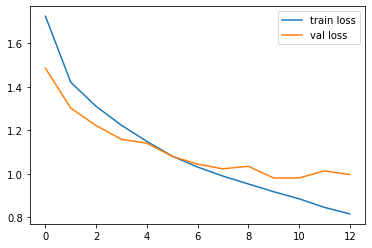

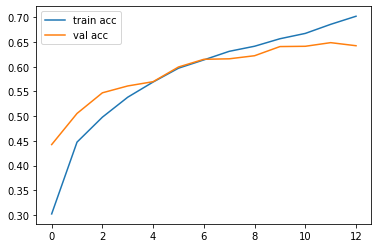

In [9]:
# plotting loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [10]:
model.save('expression_recognition_vgg.h5')